### Producing distance plots from the ICU20201 sensor outputs

In [33]:
import os
import pandas as pd
import numpy as np
import io
import re
import matplotlib.pyplot as plt

DATAPATH = "data/stereo/stereo_plastic_crd_27hz/"
MATERIAL = "plastic"
MEDIUM = "air"
FREQ = 27
sen0 = "cone"
sen1 = "no_cone"

### Function to parse one file

In [2]:
import pandas as pd
import numpy as np
import io

def analyze_range_stats(filepath, material, medium, frequency, distance):
    """
    Parses a sensor data file and computes statistics on the measured range.

    Args:
        filepath (str): Path to the .txt file (CSV-formatted).
        material (str): Type of material (e.g., "rock").
        medium (str): Surrounding medium (e.g., "water").
        frequency (float): Frequency in Hz (e.g., 2564.0).
        distance (float): Ground truth distance in cm.

    Returns:
        dict: Summary with mean, std deviation, mean absolute error, and number of readings.
    """
    # Find the header line
    with open(filepath, 'r') as f:
        lines = f.readlines()

    header_line_index = None
    for i, line in enumerate(lines):
        if line.startswith("# time [s],tx_id"):
            header_line_index = i
            break

    if header_line_index is None:
        raise ValueError("Header line with 'range [cm]' not found.")

    # Parse header and read data
    header_line = lines[header_line_index].lstrip("#").strip()
    columns = [col.strip() for col in header_line.split(',')]
    data_lines = lines[header_line_index + 1:]
    df = pd.read_csv(io.StringIO("".join(data_lines)), names=columns)

    # Extract and clean 'range [cm]'
    if 'range [cm]' not in df.columns:
        raise ValueError("'range [cm]' column not found in file.")
    
    range_values = df['range [cm]'].dropna()

    # Compute statistics
    mean_range = range_values.mean()
    std_range = range_values.std()
    abs_error = np.abs(range_values - distance).mean()
    num_readings = len(range_values)

    return {
        "material": material,
        "medium": medium,
        "frequency_hz": frequency,
        "ground_truth_cm": distance,
        "mean_range_cm": float(mean_range),
        "std_dev_cm": float(std_range),
        "mean_absolute_error_cm": float(abs_error),
        "num_readings": int(num_readings)
    }


In [ ]:
# Sample usage
result = analyze_range_stats(
    filepath=DATAPATH + "water-plastic-25hz-200mm_SmartSonic2AM_2025-08-06_11-46-21.txt",
    material=MATERIAL,
    medium=MEDIUM,
    frequency=FREQ,
    distance=20
)

print(result)

{'material': 'plastic', 'medium': 'water', 'frequency_hz': 25, 'ground_truth_cm': 20, 'mean_range_cm': 33.115957481525946, 'std_dev_cm': 0.0534913691117641, 'mean_absolute_error_cm': 13.115957481525948, 'num_readings': 136}


Finding all files to parse

In [5]:
# Distances are hard-coded for now, but can be parameterized later
# DISTANCES = [340, 390, 440, 490, 540, 590, 640, 690, 740, 790, 840, 890]
# DISTANCES = [440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, \
#             455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470]
DISTANCES = [200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850]
# DISTANCES = [110, 140, 170, 200, 210, 240, 270, 300]
print(len(DISTANCES), "distances")

14 distances


In [18]:
# Relies on having one reading per distance
def get_distance_file_map(data_folder, distances):
    """
    Collects valid data file paths for each target distance.

    Args:
        data_folder (str): Folder path containing the data files.
        distances (list[int]): Distances in mm to match in filenames.

    Returns:
        dict[int, list[str]]: Mapping from distance (mm) to list of file paths.
    """
    distance_file_map = {d: [] for d in distances}

    for fname in os.listdir(data_folder):
        if not fname.endswith('.txt'):
            continue
        if fname.endswith('algo.txt'):
            continue

        for d in distances:
            if f"{d}mm" in fname:
                full_path = os.path.join(data_folder, fname)
                distance_file_map[d].append(full_path)
                break  # Avoid double-adding to multiple distances

    return distance_file_map

# Building the full file map
file_map = get_distance_file_map(DATAPATH, DISTANCES)

In [12]:
# Verifying the right files are collected
print("200mm files:", file_map[200])
print("450mm files:", file_map[450])


200mm files: ['data/frequency_testing/cone_plastic_25hz/water-plastic-25hz-200mm_SmartSonic2AM_2025-08-06_11-46-21.txt']
450mm files: ['data/frequency_testing/cone_plastic_25hz/water-plastic-25hz-450mm_SmartSonic2AM_2025-08-06_11-51-22.txt']


In [13]:
# Gathering all the data from each distance
mean_ranges = []
absolute_differences = []
standard_deviations = []

for dist in DISTANCES:
    files = file_map[dist]
    for fpath in files:
        result = analyze_range_stats(
            filepath=fpath,
            material=MATERIAL,
            medium=MEDIUM,
            frequency=FREQ,
            distance=dist / 10.0  # convert mm to cm
        )
        mean_ranges.append(result["mean_range_cm"])
        absolute_differences.append(result["mean_absolute_error_cm"])
        standard_deviations.append(result["std_dev_cm"])

print("Mean Ranges (cm):", mean_ranges)
print("Length: ", len(mean_ranges))
print("Mean Absolute Errors (cm):", absolute_differences)
print("Length: ", len(absolute_differences))
print("Standard Deviations (cm):", standard_deviations)
print("Length: ", len(standard_deviations))

Mean Ranges (cm): [33.115957481525946, 32.66107718114399, 33.019141442566564, 34.48475947865383, 39.693137568637766, 45.17272407545656, 50.413241982353064, 55.09797509292756, 60.225550826012636, 65.01513225362497, 70.10622190278566, 74.434566923723, 79.72249465669101, 84.17537280284914]
Length:  14
Mean Absolute Errors (cm): [13.115957481525948, 7.661077181143981, 3.0191414425665593, 0.5152405213461668, 0.3068624313622301, 0.17272407545656068, 0.4132419823530639, 0.10037140692892091, 0.22555082601263438, 0.04541033592218015, 0.1491970916834233, 0.5654330762769912, 0.27750534330899884, 0.8246271971508563]
Length:  14
Standard Deviations (cm): [0.0534913691117641, 1.4419878846569112, 0.02778380121344834, 0.022675745234556375, 0.009067125421205212, 0.08090973333489472, 0.07581806864660715, 0.0811796267590872, 0.08761407148189304, 0.06448694799766855, 0.16978592357023342, 0.18607493492814117, 0.015649644772994405, 0.08441304091425236]
Length:  14


For storage and retrieval of analyzed data, to avoid repeating computations

In [14]:
output_dir = "data/frequency_testing/analyzed_cone_plastic_25hz/"
os.makedirs(output_dir, exist_ok=True)

# Build a DataFrame
df = pd.DataFrame({
    "distance_mm": DISTANCES,
    "mean_range_cm": mean_ranges,
    "mean_absolute_error_cm": absolute_differences,
    "std_dev_cm": standard_deviations,
    "material": MATERIAL,
    "medium": MEDIUM,
    "frequency_hz": FREQ
})

# Save as CSV
output_path = os.path.join(output_dir, "range_statistics.csv")
df.to_csv(output_path, index=False)
print(f"Saved stats to: {output_path}")

Saved stats to: data/frequency_testing/analyzed_cone_plastic_25hz/range_statistics.csv


In [ ]:
import pandas as pd

# Load CSV from output directory
load_path = "data/analyzed_helbling_rock_test/range_statistics.csv"
df_loaded = pd.read_csv(load_path)

# Confirm
print("Loaded data:")
display(df_loaded.head())

Finally, plotting

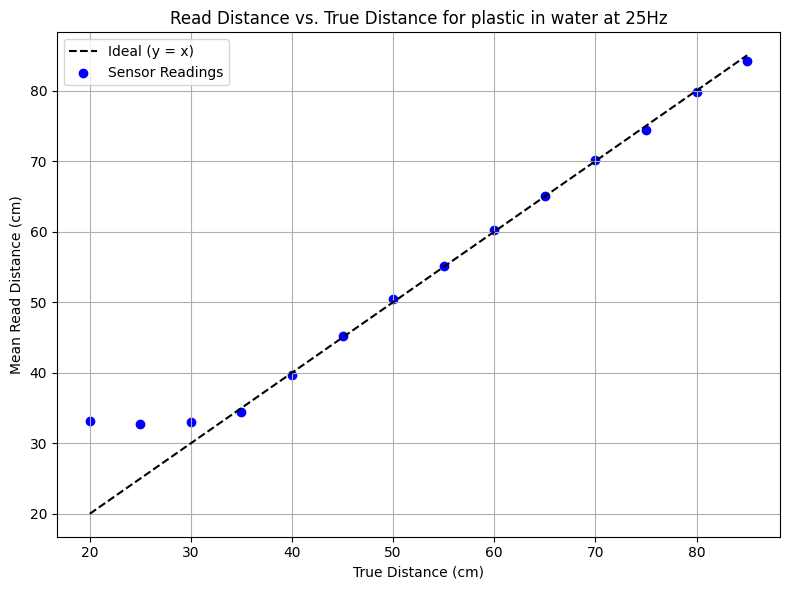

In [15]:
# Graph 1: Read Distance vs True Distance
true_distances_cm = np.array(DISTANCES) / 10.0
mean_ranges_np = np.array(mean_ranges)

plt.figure(figsize=(8, 6))
plt.plot(true_distances_cm, true_distances_cm, 'k--', label="Ideal (y = x)")
plt.scatter(true_distances_cm, mean_ranges_np, color='blue', label="Sensor Readings")

plt.xlabel("True Distance (cm)")
plt.ylabel("Mean Read Distance (cm)")
plt.title("Read Distance vs. True Distance for " + f"{MATERIAL} in {MEDIUM} at {FREQ}Hz")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "read_vs_true_distance.png"))
plt.show()

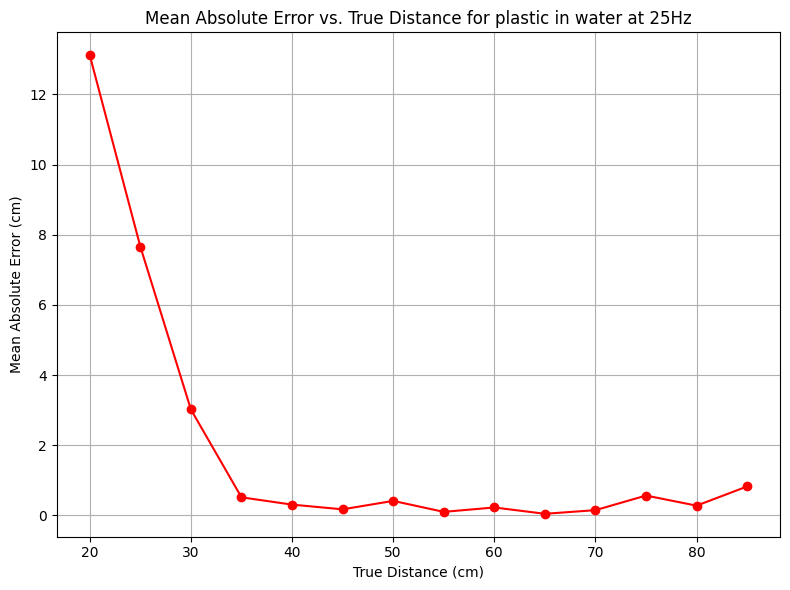

In [16]:
# Graph 2: Mean Absolute Error vs True Distance
abs_errors_np = np.array(absolute_differences)

plt.figure(figsize=(8, 6))
plt.plot(true_distances_cm, abs_errors_np, marker='o', color='red')

plt.xlabel("True Distance (cm)")
plt.ylabel("Mean Absolute Error (cm)")
plt.title("Mean Absolute Error vs. True Distance for " + f"{MATERIAL} in {MEDIUM} at {FREQ}Hz")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "absolute_error_vs_distance.png"))
plt.show()


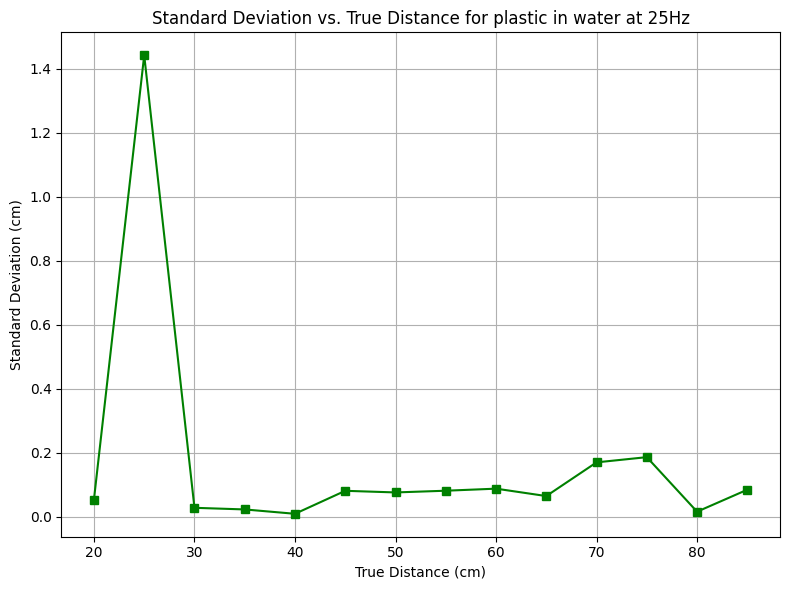

In [17]:
# Graph 3: Standard Deviation vs True Distance
std_devs_np = np.array(standard_deviations)

plt.figure(figsize=(8, 6))
plt.plot(true_distances_cm, std_devs_np, marker='s', color='green')

plt.xlabel("True Distance (cm)")
plt.ylabel("Standard Deviation (cm)")
plt.title("Standard Deviation vs. True Distance for " + f"{MATERIAL} in {MEDIUM} at {FREQ}Hz")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "std_dev_vs_distance.png"))
plt.show()


In [45]:
def plot_range_vs_time(filepath, title=None):
    """
    Plots range measurements over time from a sensor data file.

    Args:
        filepath (str): Path to the .txt file containing sensor data.
        title (str, optional): Plot title. If None, defaults to filename.
    """
    # Read the file and locate the header
    with open(filepath, 'r') as f:
        lines = f.readlines()

    header_index = None
    for i, line in enumerate(lines):
        if line.startswith("# time [s],tx_id"):
            header_index = i
            break

    if header_index is None:
        raise ValueError("Could not find the data header line.")

    header_line = lines[header_index].lstrip("#").strip()
    columns = [col.strip() for col in header_line.split(',')]
    data_lines = lines[header_index + 1:]

    df = pd.read_csv(io.StringIO("".join(data_lines)), names=columns)

    # Ensure required columns exist
    if 'time [s]' not in df.columns or 'range [cm]' not in df.columns:
        raise ValueError("Missing required columns: 'time [s]' and 'range [cm]'")

    # Drop NaNs
    df = df[['time [s]', 'range [cm]']].dropna()

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(df['time [s]'], df['range [cm]'], marker='.', linestyle='-', color='navy')
    plt.xlabel("Time (s)")
    plt.ylabel("Range (cm)")
    plt.title(title or f"Range vs Time: {filepath}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

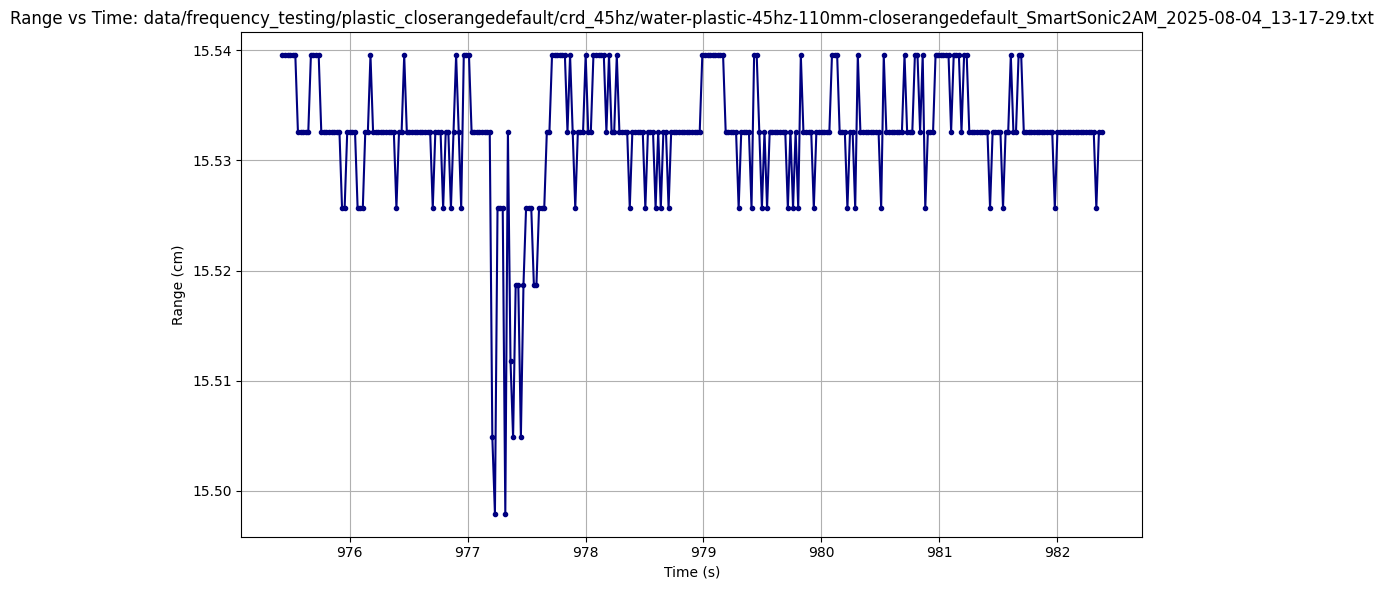

In [57]:
# plot_range_vs_time(DATAPATH+"water-buoy-2564hz-712mm_test2_SmartSonic2AM_2025-07-29_12-29-29.txt")
plot_range_vs_time(DATAPATH+"water-plastic-45hz-110mm-closerangedefault_SmartSonic2AM_2025-08-04_13-17-29.txt")

### Function to parse two sensor files

In [35]:
def analyze_dual_sensor_range_stats(filepath, material, medium, frequency, distance):
    """
    Parses a dual-sensor data file (alternating rows) and computes stats
    separately for sensor 0 and sensor 1.

    Args:
        filepath (str): Path to the .txt file (CSV-formatted).
        material (str): Type of material (e.g., "rock").
        medium (str): Surrounding medium (e.g., "water").
        frequency (float): Frequency in Hz (e.g., 2564.0).
        distance (float): Ground truth distance in cm.

    Returns:
        dict: Stats for each sensor under keys "sensor_0" and "sensor_1".
    """
    # --- load and locate header ---
    with open(filepath, 'r') as f:
        lines = f.readlines()

    header_idx = next((i for i, l in enumerate(lines) if l.startswith("# time [s],tx_id")), None)
    if header_idx is None:
        raise ValueError("Couldn't find header line starting with '# time [s],tx_id'")

    header = lines[header_idx].lstrip("#").strip()
    cols   = [c.strip() for c in header.split(",")]
    data   = "".join(lines[header_idx+1:])
    df     = pd.read_csv(io.StringIO(data), names=cols)

    # Drop any rows where 'range [cm]' is still the header string
    df = df[df['range [cm]'] != 'range [cm]']

    if "range [cm]" not in df:
        raise ValueError("No 'range [cm]' column in data")

    # --- split alternating rows ---
    df0 = df.iloc[::2].reset_index(drop=True)  # sensor 0
    df1 = df.iloc[1::2].reset_index(drop=True) # sensor 1

    def stats(subdf):
        vals = pd.to_numeric(subdf["range [cm]"], errors='coerce').dropna()
        return {
            "mean_range_cm":             float(vals.mean()),
            "std_dev_cm":                float(vals.std()),
            "mean_absolute_error_cm":    float((vals - distance).abs().mean()),
            "num_readings":              int(vals.count())
        }

    return {
        "sensor_0": {
            "sensor_id":       0,
            "material":        material,
            "medium":          medium,
            "frequency_hz":    frequency,
            "ground_truth_cm": distance,
            **stats(df0)
        },
        "sensor_1": {
            "sensor_id":       1,
            "material":        material,
            "medium":          medium,
            "frequency_hz":    frequency,
            "ground_truth_cm": distance,
            **stats(df1)
        }
    }


In [36]:
# Sample usage
result = analyze_dual_sensor_range_stats(
    filepath=DATAPATH + "air-plastic-crd-dual-27hz-200mm_SmartSonic2AM_2025-08-07_14-35-25.txt",
    material=MATERIAL,
    medium=MEDIUM,
    frequency=FREQ,
    distance=20
)

print(result)

{'sensor_0': {'sensor_id': 0, 'material': 'plastic', 'medium': 'air', 'frequency_hz': 27, 'ground_truth_cm': 20, 'mean_range_cm': 15.806898429287484, 'std_dev_cm': 0.02124917156042625, 'mean_absolute_error_cm': 4.193101570712516, 'num_readings': 161}, 'sensor_1': {'sensor_id': 1, 'material': 'plastic', 'medium': 'air', 'frequency_hz': 27, 'ground_truth_cm': 20, 'mean_range_cm': 14.805978432473449, 'std_dev_cm': 0.031070705593821964, 'mean_absolute_error_cm': 5.1940215675265495, 'num_readings': 160}}


In [51]:
# Distances are hard-coded for now, but can be parameterized later
# DISTANCES = [340, 390, 440, 490, 540, 590, 640, 690, 740, 790, 840, 890]
# DISTANCES = [440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, \
#             455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470]
DISTANCES = [200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, \
             380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550]
# DISTANCES = [110, 140, 170, 200, 210, 240, 270, 300]
print(len(DISTANCES), "distances")

36 distances


In [52]:
def get_distance_file_map_recursive(data_folder, distances):
    """
    Recursively collects valid data file paths for each target distance.

    Args:
        data_folder (str): Root folder containing the data files (can include subfolders).
        distances (list[int]): Distances in mm to match in filenames.

    Returns:
        dict[int, list[str]]: Mapping from distance (mm) to list of full file paths.
    """
    distance_file_map = {d: [] for d in distances}

    for root, _, files in os.walk(data_folder):
        for fname in files:
            if not fname.endswith('.txt') or fname.endswith('algo.txt'):
                continue

            for d in distances:
                if f"{d}mm" in fname:
                    full_path = os.path.join(root, fname)
                    distance_file_map[d].append(full_path)
                    break  # Avoid adding to multiple distances

    return distance_file_map

file_map = get_distance_file_map_recursive(DATAPATH, DISTANCES)

In [53]:
# Verifying the right files are collected
print("200mm files:", file_map[200])
print("540mm files:", file_map[540])

200mm files: ['data/stereo/stereo_plastic_crd_27hz/air-plastic-crd-dual-27hz-200mm_SmartSonic2AM_2025-08-07_14-35-25.txt']
540mm files: ['data/stereo/stereo_plastic_crd_27hz/air-plastic-crd-dual-27hz-540mm_SmartSonic2AM_2025-08-07_15-26-13.txt']


In [54]:
# Gathering all the data from each distance for sensor 0 and sensor 1
mean_ranges_0 = []
absolute_differences_0 = []
standard_deviations_0 = []

mean_ranges_1 = []
absolute_differences_1 = []
standard_deviations_1 = []

for dist in DISTANCES:
    files = file_map[dist]
    for fpath in files:
        result = analyze_dual_sensor_range_stats(
            filepath=fpath,
            material=MATERIAL,
            medium=MEDIUM,
            frequency=FREQ,
            distance=dist / 10.0  # convert mm to cm
        )
        # Sensor 0 data
        mean_ranges_0.append(result["sensor_0"]["mean_range_cm"])
        absolute_differences_0.append(result["sensor_0"]["mean_absolute_error_cm"])
        standard_deviations_0.append(result["sensor_0"]["std_dev_cm"])

        # Sensor 1 data
        mean_ranges_1.append(result["sensor_1"]["mean_range_cm"])
        absolute_differences_1.append(result["sensor_1"]["mean_absolute_error_cm"])
        standard_deviations_1.append(result["sensor_1"]["std_dev_cm"])

# Print summaries
print(f"Sensor {sen0} - Mean Ranges (cm):", mean_ranges_0)
print(f"Sensor {sen0} - Mean Absolute Errors (cm):", absolute_differences_0)
print(f"Sensor {sen0} - Standard Deviations (cm):", standard_deviations_0)
print("------------------------------------------------------------------")
print(f"Sensor {sen1} - Mean Ranges (cm):", mean_ranges_1)
print(f"Sensor {sen1} - Mean Absolute Errors (cm):", absolute_differences_1)
print(f"Sensor {sen1} - Standard Deviations (cm):", standard_deviations_1)


Sensor cone - Mean Ranges (cm): [15.806898429287484, 15.746005580495634, 16.214633124380732, 17.176700810433996, 18.65984095562561, 21.602268476524095, 24.948109372390228, 26.195507096401457, 22.569809879890006, 23.25215168140256, 23.87438212015669, 26.640913169368154, 25.79301188328271, 26.58967712197563, 28.57063514968351, 28.6065900982496, 29.83748657812554, 30.859632435580885, 31.793270558980474, 38.52418556370752, 39.61738056893378, 41.09437989008942, 42.75594894843963, 43.51806046809151, 43.783801249347405, 45.19094711882605, 46.50880159592246, 47.76527968260188, 47.916398530138345, 48.80278111461891, 49.41780817687748, 50.596875, 47.93035322615578, 48.05264147691511, 48.34489921438981, 56.65582299219185]
Sensor cone - Mean Absolute Errors (cm): [4.193101570712516, 5.253994419504369, 5.785366875619268, 5.823299189566006, 5.34015904437439, 3.3977315234759047, 1.0518906276097757, 0.8044929035985449, 5.430190120109993, 5.74784831859744, 6.12561787984331, 4.359086830631843, 6.2069881

In [55]:
output_dir = "data/stereo/analyzed_stereo_plastic_crd_27hz/"
os.makedirs(output_dir, exist_ok=True)


df = pd.DataFrame({
    "distance_mm": DISTANCES,

    # Sensor 0
    "mean_range_cm_sensor_0": mean_ranges_0,
    "mean_absolute_error_cm_sensor_0": absolute_differences_0,
    "std_dev_cm_sensor_0": standard_deviations_0,

    # Sensor 1
    "mean_range_cm_sensor_1": mean_ranges_1,
    "mean_absolute_error_cm_sensor_1": absolute_differences_1,
    "std_dev_cm_sensor_1": standard_deviations_1,

    # Metadata
    "sensor_0_type": [sen0] * len(DISTANCES),
    "sensor_1_type": [sen1] * len(DISTANCES),
    "material": [MATERIAL] * len(DISTANCES),
    "medium": [MEDIUM] * len(DISTANCES),
    "frequency_hz": [FREQ] * len(DISTANCES)
})

# print(df)
output_path = os.path.join(output_dir, "dual_sensor_range_statistics.csv")
df.to_csv(output_path, index=False)
print(f"Saved dual sensor stats to: {output_path}")

Saved dual sensor stats to: data/stereo/analyzed_stereo_plastic_crd_27hz/dual_sensor_range_statistics.csv


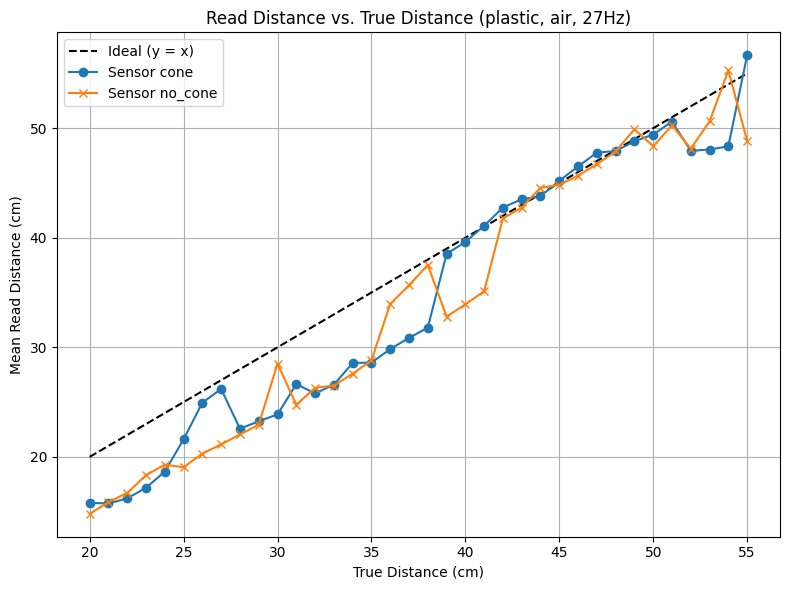

In [56]:
true_distances_cm = np.array(DISTANCES) / 10.0

plt.figure(figsize=(8, 6))
plt.plot(true_distances_cm, true_distances_cm, 'k--', label="Ideal (y = x)")
plt.plot(true_distances_cm, mean_ranges_0, marker='o', label=f"Sensor {sen0}")
plt.plot(true_distances_cm, mean_ranges_1, marker='x', label=f"Sensor {sen1}")

plt.xlabel("True Distance (cm)")
plt.ylabel("Mean Read Distance (cm)")
plt.title(f"Read Distance vs. True Distance ({MATERIAL}, {MEDIUM}, {FREQ}Hz)")
plt.legend()
plt.grid(True)
plt.tight_layout()

output_path = os.path.join(output_dir, "mean_read_distance_comparison.png")
plt.savefig(output_path)
plt.show()


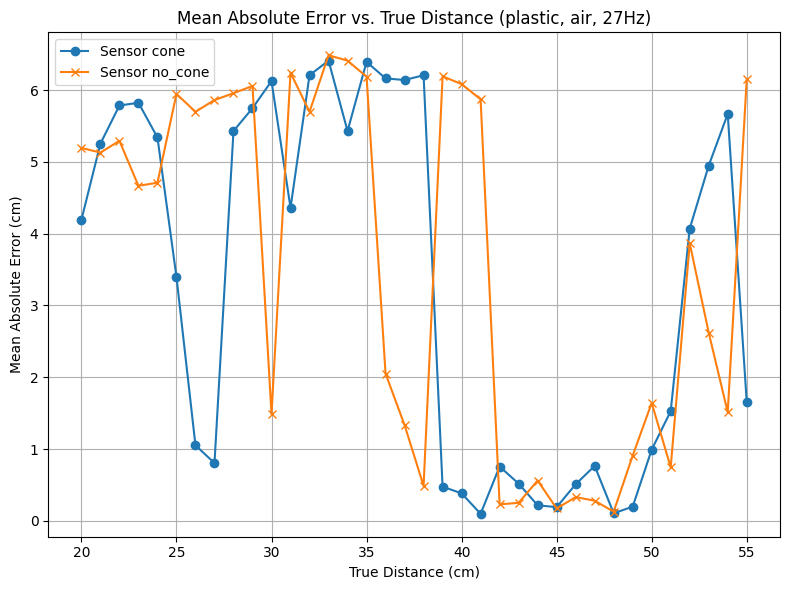

In [57]:
plt.figure(figsize=(8, 6))
plt.plot(true_distances_cm, absolute_differences_0, marker='o', label=f"Sensor {sen0}")
plt.plot(true_distances_cm, absolute_differences_1, marker='x', label=f"Sensor {sen1}")

plt.xlabel("True Distance (cm)")
plt.ylabel("Mean Absolute Error (cm)")
plt.title(f"Mean Absolute Error vs. True Distance ({MATERIAL}, {MEDIUM}, {FREQ}Hz)")
plt.legend()
plt.grid(True)
plt.tight_layout()

output_path = os.path.join(output_dir, "mean_absolute_error_comparison.png")
plt.savefig(output_path)
plt.show()


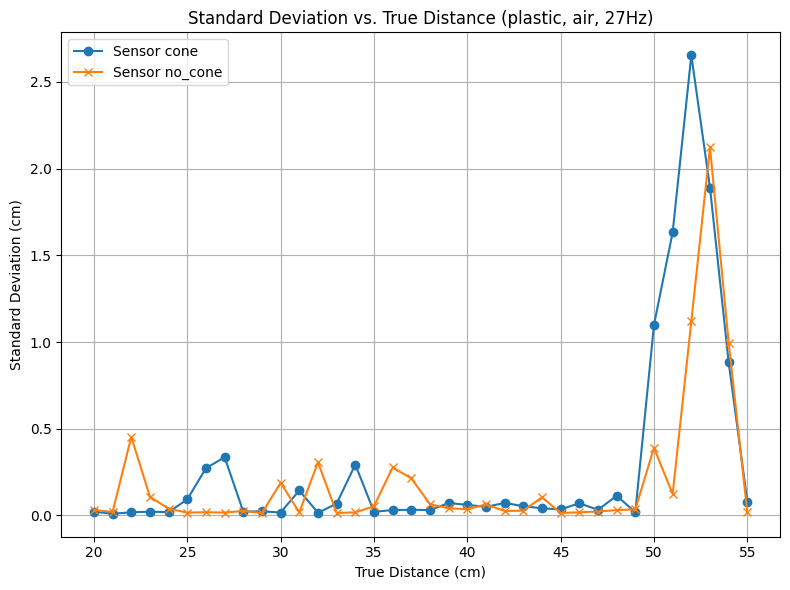

In [58]:
plt.figure(figsize=(8, 6))
plt.plot(true_distances_cm, standard_deviations_0, marker='o', label=f"Sensor {sen0}")
plt.plot(true_distances_cm, standard_deviations_1, marker='x', label=f"Sensor {sen1}")

plt.xlabel("True Distance (cm)")
plt.ylabel("Standard Deviation (cm)")
plt.title(f"Standard Deviation vs. True Distance ({MATERIAL}, {MEDIUM}, {FREQ}Hz)")
plt.legend()
plt.grid(True)
plt.tight_layout()

output_path = os.path.join(output_dir, "standard_deviation_comparison.png")
plt.savefig(output_path)
plt.show()
